In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# Load your pretrained model.
model = load_model(r"C:\Users\theof\OneDrive - Imperial College London\Imperial MSc\AML Project\AML-Project\new_collect\fzh\rnn_emg_model.h5")

# Create a dummy input with the correct shape: (batch_size, timesteps, features)
x = np.random.randn(1, 19, 1000).astype(np.float32)
x = tf.convert_to_tensor(x)

with tf.GradientTape() as tape:
    tape.watch(x)
    # Forward pass.
    predictions = model(x)
    # If the output isn't a scalar, select one component, e.g., the first output.
    target_output = predictions[0, 0]

# Compute gradients of the target output with respect to the input.
grads = tape.gradient(target_output, x)
saliency = tf.abs(grads).numpy()
print(saliency)


[[[5.26206677e-05 9.72644193e-05 2.10081285e-04 ... 8.47001138e-05
   2.92264758e-05 8.42662848e-05]
  [3.52276402e-06 1.14959184e-04 1.06743348e-04 ... 5.36759362e-05
   3.94180170e-05 1.00298290e-04]
  [3.77671604e-05 1.96874476e-04 1.54632857e-04 ... 7.59969844e-05
   2.79203232e-06 1.76379617e-05]
  ...
  [2.51352249e-05 6.63928513e-05 1.55649090e-04 ... 1.36923554e-04
   4.10830071e-05 1.31160516e-04]
  [4.33996320e-07 4.59053663e-05 2.86932554e-05 ... 1.54847748e-05
   8.65091861e-05 1.50336622e-04]
  [4.63197794e-05 4.23837901e-06 1.26611249e-05 ... 2.43558861e-05
   5.98046026e-05 5.54274011e-05]]]


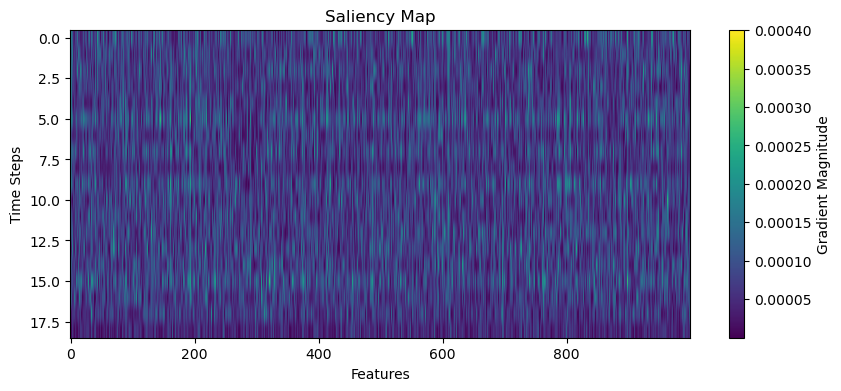

In [2]:
import matplotlib.pyplot as plt

# Assume saliency has shape (1, timesteps, features)
saliency_map = saliency[0]  # remove the batch dimension

plt.figure(figsize=(10, 4))
plt.imshow(saliency_map, aspect="auto", cmap="viridis")
plt.colorbar(label='Gradient Magnitude')
plt.xlabel("Features")
plt.ylabel("Time Steps")
plt.title("Saliency Map")
plt.show()


In [3]:
import tensorflow as tf
import numpy as np
import os
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D

# X_train = np.nan_to_num(X_train, nan=0.0)

def load_data(root_path, test_size=0.2, random_state=42):
    """
    加载预处理的手势数据，并拆分为训练集和测试集。
    
    参数：
    root_path (str): 存储 processed_gesture_data.npy 和 gesture_labels.npy 的根目录
    test_size (float): 测试集比例，默认 20%
    random_state (int): 随机种子，确保可复现性
    
    返回：
    X_train, X_test, y_train, y_test: 训练集和测试集的数据及标签
    """
    data_path = os.path.join(root_path, "processed_gesture_data.npy")
    label_path = os.path.join(root_path, "gesture_labels.npy")
    
    if not os.path.exists(data_path) or not os.path.exists(label_path):
        raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")
    
    print("Loading processed data...")
    X = np.load(data_path,allow_pickle=True)
    y = np.load(label_path,allow_pickle=True)
    
    print(f"Data shape: {X.shape}, Labels shape: {y.shape}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

data_folder = r"new_collect\fzh"  
X_train, X_test, y_train, y_test = load_data(data_folder)
# X_train = np.nan_to_num(X_train, nan=0.0)
# X_test = np.nan_to_num(X_test, nan=0.0)
# y_train = np.nan_to_num(y_train, nan = 0.0)
# y_test = np.nan_to_num(y_test, nan = 0.0)
# **获取数据形状**
num_batches = X_train.shape[0]  # batch 维度
num_windows = X_train.shape[1]  # 时间步（窗口数 59）
num_features = X_train.shape[2]  # 特征数（15）
num_channels = X_train.shape[3]  # 通道数（1）

# **检测类别数量**
unique_classes = np.unique(y_train)
num_classes = len(unique_classes)  # 确保类别数正确

print(f"Corrected Classes: {num_classes}, Batches: {num_batches}, Windows: {num_windows}, Features: {num_features}, Channels: {num_channels}")

# **保持 X 形状**
X_train = X_train.reshape(num_batches, num_windows, num_features, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_windows, num_features, num_channels)
# X_train = X_train[:,:,:,:]
# X_test = X_test[:,:,:,:]

# print(X_train.shape)

num_features = X_train.shape[2] 
num_channels = X_train.shape[3]
# **标签编码**
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)  # 转换成 0,1,2
y_test = encoder.transform(y_test)

# **转换为 One-Hot**
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")  # (batch, 59, 15, 1) (batch, 3)
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")  # (batch, 59, 15, 1) (batch, 3)


X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)  # (batch_size, 29, 40)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)  

# Suppose we take one sample from X_test
x = X_test[:1]  # shape (1, 59, 15)

x_tensor = tf.convert_to_tensor(x)
with tf.GradientTape() as tape:
    tape.watch(x_tensor)
    predictions = model(x_tensor)
    # For a classification model with multiple classes, pick the predicted class:
    predicted_class = tf.argmax(predictions[0])
    # Or directly index that logit's value:
    target_logit = predictions[0, predicted_class]

grads = tape.gradient(target_logit, x_tensor)  # shape (1, 59, 15)
saliency = tf.abs(grads).numpy()


Loading processed data...
Data shape: (574, 19, 100, 10), Labels shape: (574,)
Training set: (459, 19, 100, 10), Testing set: (115, 19, 100, 10)
Corrected Classes: 23, Batches: 459, Windows: 19, Features: 100, Channels: 10
X_train shape: (459, 19, 100, 10), y_train shape: (459, 23)
X_test shape: (115, 19, 100, 10), y_test shape: (115, 23)


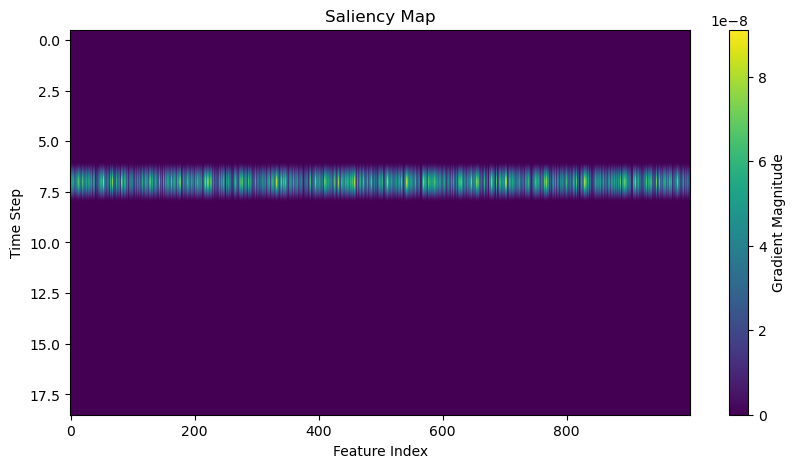

In [4]:
import matplotlib.pyplot as plt

# Remove the batch dimension: (59, 15)
sal_map = saliency[0]

plt.figure(figsize=(10, 5))
plt.imshow(sal_map, aspect='auto', cmap='viridis')
plt.colorbar(label='Gradient Magnitude')
plt.xlabel("Feature Index")
plt.ylabel("Time Step")
plt.title("Saliency Map")
plt.show()


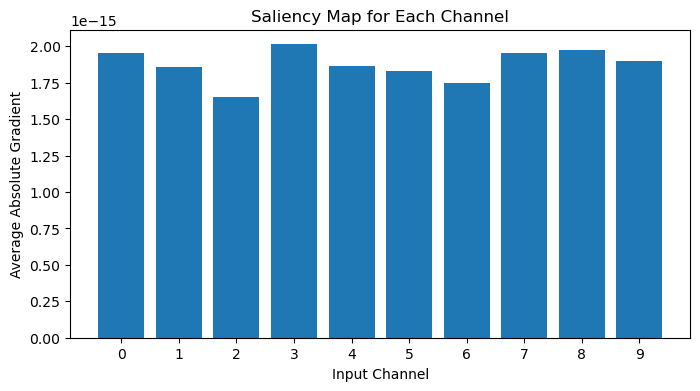

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# Load your pretrained model.
model = load_model(r"C:\Users\theof\OneDrive - Imperial College London\Imperial MSc\AML Project\AML-Project\new_collect\fzh\rnn_emg_model.h5")


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



# Your original sample input shape: (1, 19, 100, 10)
sample_input = np.random.rand(1, 19, 100, 10).astype(np.float32)


# Reshape to (1, 19, 1000) to match model expectations.
sample_input_reshaped = sample_input.reshape(1, 19, 1000)

# Suppose we take one sample from X_test
x = X_test[:1]  # shape (1, 59, 15)

# Convert to tensor and compute gradients.
input_tensor = tf.convert_to_tensor(x)
with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    prediction = model(input_tensor)

# Compute gradients (shape: (1, 19, 1000))
grads = tape.gradient(prediction, input_tensor).numpy()

# Reshape gradients back to (1, 19, 100, 10) to correspond to the original channel dimensions.
grads_reshaped = grads.reshape(1, 19, 100, 10)

# Average the absolute gradients over the temporal dimensions (19 and 100) for each channel.
saliency = np.mean(np.abs(grads_reshaped), axis=(1, 2)).squeeze()  # Shape: (10,)

# Plot the saliency map.
plt.figure(figsize=(8, 4))
plt.bar(range(10), saliency)
plt.xlabel("Input Channel")
plt.ylabel("Average Absolute Gradient")
plt.title("Saliency Map for Each Channel")
plt.xticks(range(10))
plt.show()



In [11]:
import os
import numpy as np
from sklearn.decomposition import PCA

# Define your root path
root_path = r"new_collect\fzh"

data_path = os.path.join(root_path, "processed_gesture_data.npy")
label_path = os.path.join(root_path, "gesture_labels.npy")

if not os.path.exists(data_path) or not os.path.exists(label_path):
    raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")

print("Loading processed data...")
X = np.load(data_path, allow_pickle=True)
y = np.load(label_path, allow_pickle=True)
print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

# Reshape data to combine the first three dimensions; each row corresponds to one observation across the 10 channels
X_reshaped = X.reshape(-1, X.shape[-1])
print(f"Reshaped data for PCA: {X_reshaped.shape}")

# Run PCA to examine channel contributions
pca = PCA(n_components=10)
pca.fit(X_reshaped)



Loading processed data...
Data shape: (574, 19, 100, 10), Labels shape: (574,)
Reshaped data for PCA: (1090600, 10)


PCA(n_components=10)

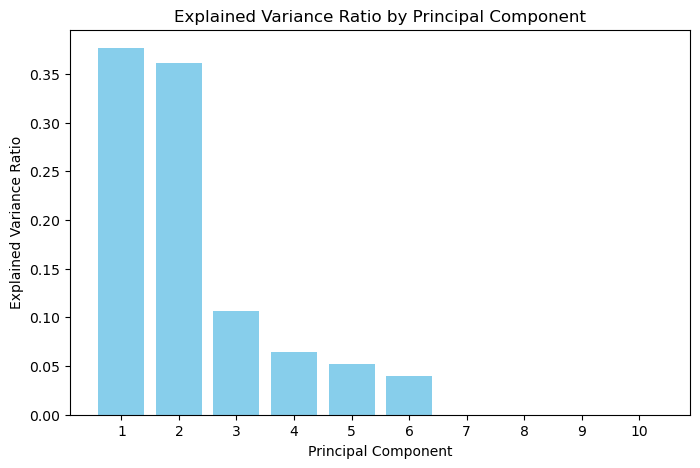

In [12]:
# Plot explained variance ratio per component
plt.figure(figsize=(8, 5))
components = np.arange(1, 11)
plt.bar(components, pca.explained_variance_ratio_, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(components)
plt.show()



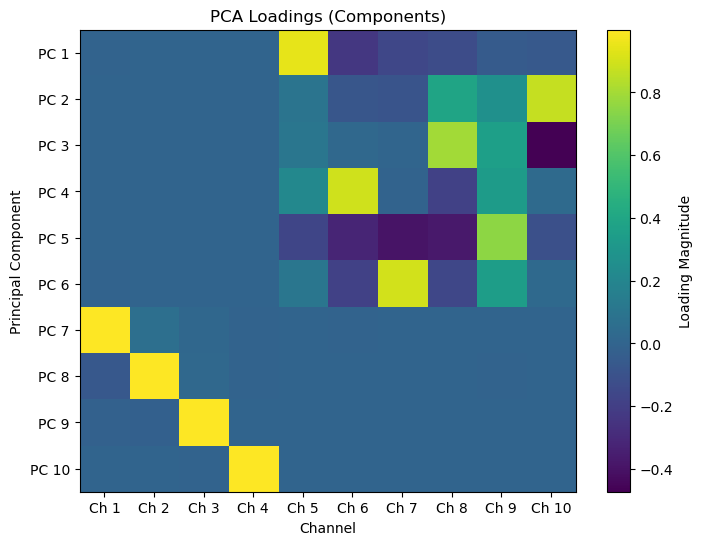

In [13]:
# Visualize the PCA loadings as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(pca.components_, aspect='auto', cmap='viridis')
plt.colorbar(label='Loading Magnitude')
plt.xlabel('Channel')
plt.ylabel('Principal Component')
plt.title('PCA Loadings (Components)')
plt.xticks(np.arange(10), [f"Ch {i+1}" for i in range(10)])
plt.yticks(np.arange(10), [f"PC {i+1}" for i in range(10)])
plt.show()

In [17]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(root_path, test_size=0.2, random_state=42):
    """Loads gesture dataset and splits into train/test sets."""
    data_path = os.path.join(root_path, "processed_gesture_data.npy")
    label_path = os.path.join(root_path, "gesture_labels.npy")
    
    if not os.path.exists(data_path) or not os.path.exists(label_path):
        raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")
    
    print("Loading processed data...")
    X = np.load(data_path, allow_pickle=True)
    y = np.load(label_path, allow_pickle=True)
    
    print(f"Data shape: {X.shape}, Labels shape: {y.shape}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

def extract_emg_features(signal, fs=1000):
    """Extracts features from an EMG signal (100 time steps)."""
    mav = np.mean(np.abs(signal))  # Mean Absolute Value
    rms = np.sqrt(np.mean(signal**2))  # Root Mean Square
    var = np.var(signal)  # Variance
    zc = np.sum(np.diff(np.sign(signal)) != 0)  # Zero Crossing Count
    wl = np.sum(np.abs(np.diff(signal)))  # Waveform Length

    # Frequency-domain features using FFT
    fft_vals = np.fft.rfft(signal)
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    power = np.abs(fft_vals)**2
    total_power = np.sum(power)
    mean_freq = np.sum(freqs * power) / total_power if total_power else 0

    cumsum_power = np.cumsum(power)
    median_freq = freqs[np.where(cumsum_power >= total_power/2)[0][0]] if total_power else 0

    return np.array([mav, rms, var, zc, wl, mean_freq, median_freq])

def synthesize_time_series(features, num_timesteps=100):
    """
    Generates a synthetic time series of length `num_timesteps` from extracted features.
    Uses Gaussian noise centered at the mean feature values.
    """
    synthesized_signal = np.zeros((num_timesteps,))
    
    for i, feature in enumerate(features):
        synthesized_signal += feature * np.sin(2 * np.pi * (i + 1) * np.linspace(0, 1, num_timesteps))
    
    return synthesized_signal + np.random.normal(0, 0.05, num_timesteps)  # Add small noise

def replace_emg_with_synthetic_data(X, fs=1000):
    """
    Replaces the first 4 EMG channels in each window with synthesized time series
    generated from extracted features, while keeping the last 6 IMU channels unchanged.

    Parameters:
    - X: Shape (num_samples, num_windows, num_timesteps, num_channels)
    - fs: Sampling frequency

    Returns:
    - X_new: Same shape as X, but with EMG channels replaced by synthetic features
    """
    num_samples, num_windows, num_timesteps, num_channels = X.shape
    new_X = np.copy(X)  # Keep the original structure

    for i in range(num_samples):
        for j in range(num_windows):
            for ch in range(4):  # Replace only the first 4 EMG channels
                features = extract_emg_features(X[i, j, :, ch], fs)
                new_X[i, j, :, ch] = synthesize_time_series(features, num_timesteps)

    return new_X

# Load original data
data_folder = r"new_collect\fzh"  
X_train, X_test, y_train, y_test = load_data(data_folder)

# Replace EMG channels with synthesized time series
X_train_new = replace_emg_with_synthetic_data(X_train, fs=1000)
X_test_new = replace_emg_with_synthetic_data(X_test, fs=1000)

print(f"New training data shape: {X_train_new.shape}")
print(f"New testing data shape: {X_test_new.shape}")


Loading processed data...
Data shape: (574, 19, 100, 10), Labels shape: (574,)
Training set: (459, 19, 100, 10), Testing set: (115, 19, 100, 10)
New training data shape: (459, 19, 100, 10)
New testing data shape: (115, 19, 100, 10)


In [20]:
# Merge train and test sets for PCA analysis
X_merged = np.concatenate([X_train_new, X_test_new], axis=0)
print(f"Merged feature data shape: {X_merged.shape}")
# Reshape data to combine the first three dimensions; each row corresponds to one observation across the 10 channels
X_reshaped = X_merged.reshape(-1, X_merged.shape[-1])
print(f"Reshaped data for PCA: {X_reshaped.shape}")

# Run PCA to examine feature contributions
pca = PCA(n_components=min(10, X_reshaped.shape[1]))  # Ensure n_components doesn't exceed feature count
pca.fit(X_reshaped)


Merged feature data shape: (574, 19, 100, 10)
Reshaped data for PCA: (1090600, 10)


PCA(n_components=10)

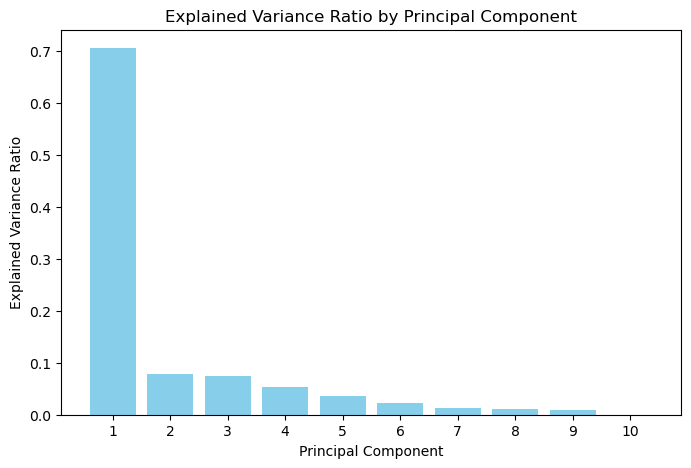

In [21]:
# Plot explained variance ratio per component
plt.figure(figsize=(8, 5))
components = np.arange(1, 11)
plt.bar(components, pca.explained_variance_ratio_, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(components)
plt.show()



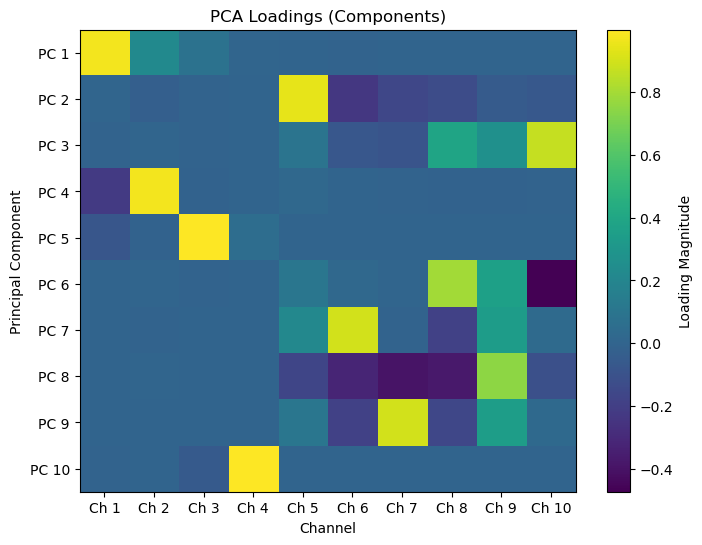

In [22]:
# Visualize the PCA loadings as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(pca.components_, aspect='auto', cmap='viridis')
plt.colorbar(label='Loading Magnitude')
plt.xlabel('Channel')
plt.ylabel('Principal Component')
plt.title('PCA Loadings (Components)')
plt.xticks(np.arange(10), [f"Ch {i+1}" for i in range(10)])
plt.yticks(np.arange(10), [f"PC {i+1}" for i in range(10)])
plt.show()

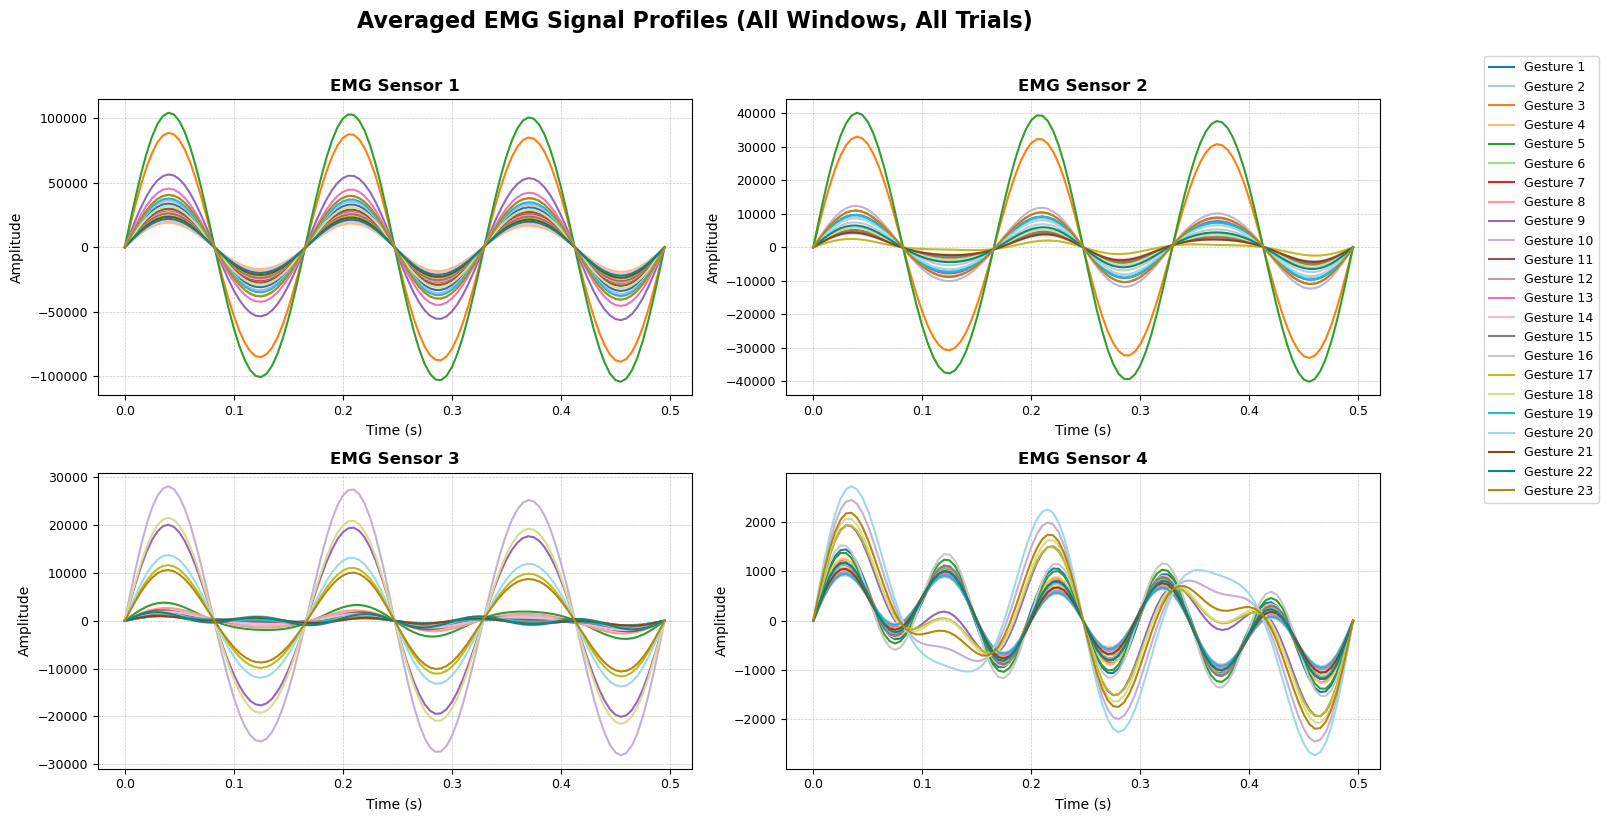

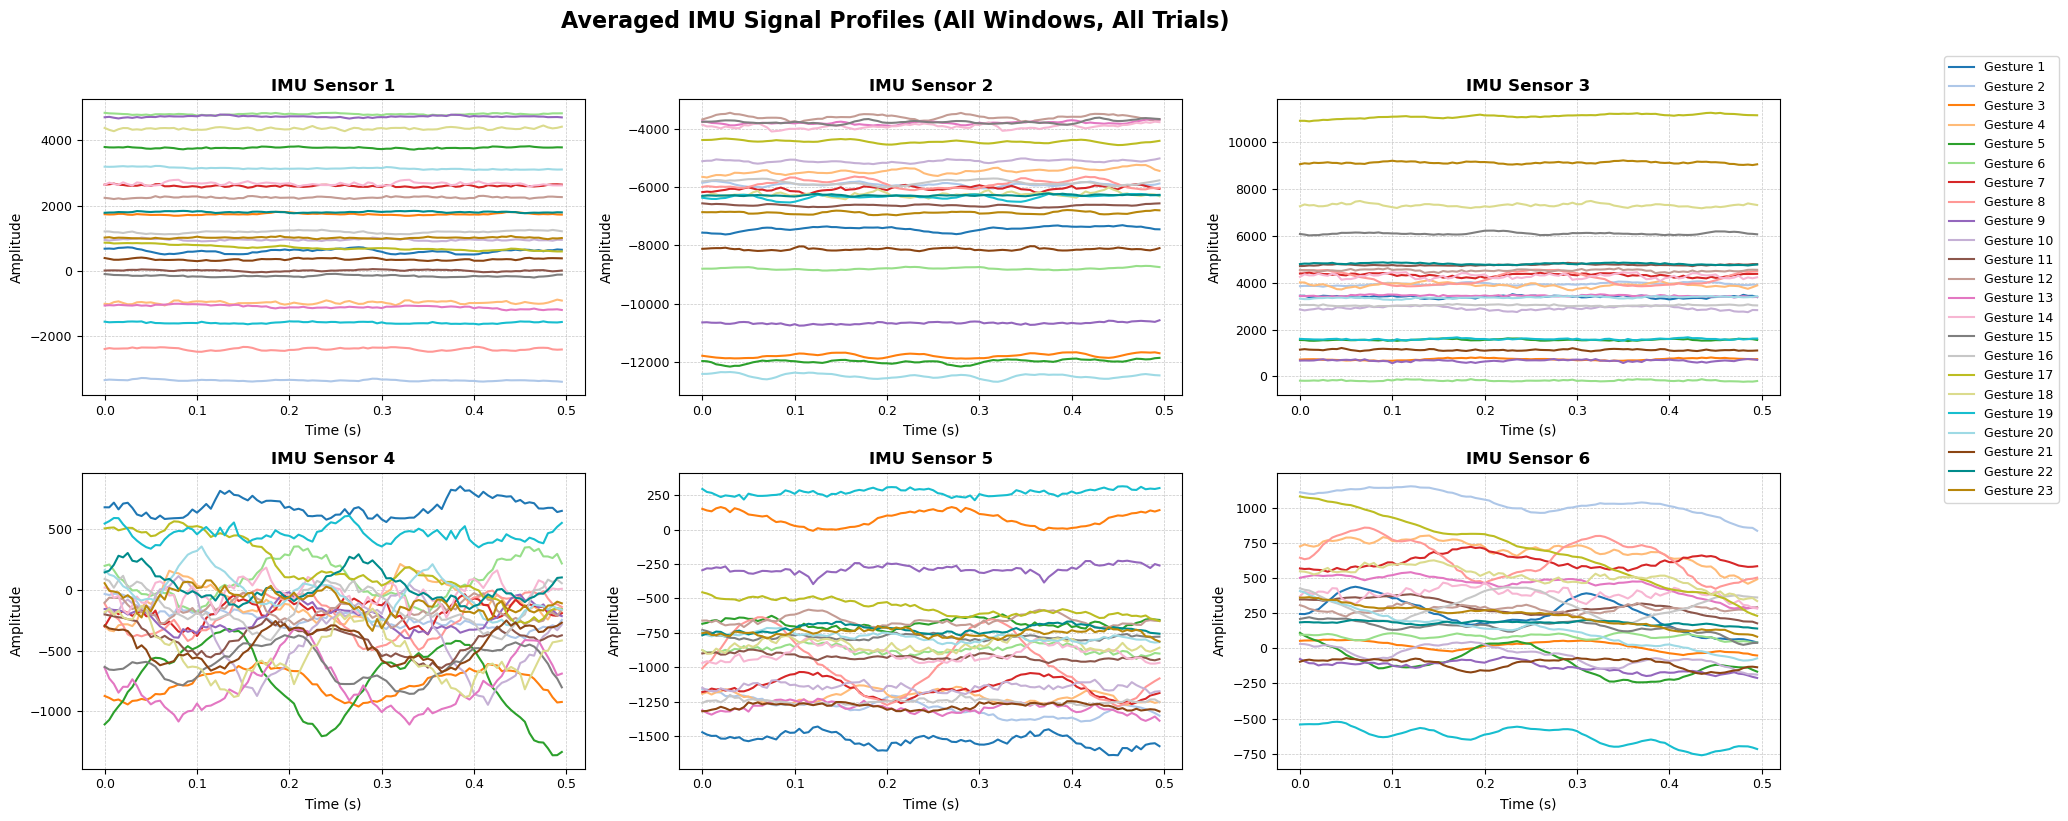

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os

##############################################################################
# USER-DEFINED PARAMETERS
##############################################################################
sampling_rate = 200  # Hz, adjust based on your setup if known (e.g., 200 Hz)
emg_channels = [0, 1, 2, 3]  # Indices of EMG sensors
imu_channels = [4, 5, 6, 7, 8, 9]  # Indices of IMU sensors

##############################################################################
# LOAD PROCESSED DATA
##############################################################################
# data_path = os.path.join(root_path, "processed_gesture_data.npy")
# label_path = os.path.join(root_path, "gesture_labels.npy")

# if not os.path.exists(data_path) or not os.path.exists(label_path):
#     raise FileNotFoundError("Processed gesture data or labels not found. "
#                             "Please run process_all_gesture_files first.")

# print("Loading processed data...")
# X = np.load(data_path, allow_pickle=True)  # Shape: (n_trials, n_windows, window_length, n_channels)
# y = np.load(label_path, allow_pickle=True)

# # Basic checks
# if X.ndim != 4:
#     raise ValueError("Expected 4D array with shape (n_trials, n_windows, window_length, n_channels).")
# print("Data shape:", X.shape)  # For debugging

X = X_merged
y = np.concatenate([y_train, y_test], axis=0)

##############################################################################
# COMPUTE AVERAGE & STD PROFILES
##############################################################################
unique_gestures = np.sort(np.unique(y))
n_gestures = len(unique_gestures)

avg_profiles = {}
std_profiles = {}

for gesture in unique_gestures:
    # Find indices of all trials for this gesture
    gesture_indices = np.where(y == gesture)[0]
    # Concatenate windows from all trials along axis=0
    # Shape => (n_trials * n_windows, window_length, n_channels)
    gesture_data = np.concatenate([X[idx] for idx in gesture_indices], axis=0)
    # Compute mean & std across the first axis (all windows)
    avg_profiles[gesture] = np.mean(gesture_data, axis=0)  # (window_length, n_channels)
    std_profiles[gesture] = np.std(gesture_data, axis=0)   # (window_length, n_channels)

##############################################################################
# PREPARE TIME AXIS
##############################################################################
# We'll convert sample indices to time in seconds: t = indices / sampling_rate
window_length = next(iter(avg_profiles.values())).shape[0]
time_axis = np.arange(window_length) / sampling_rate  # shape: (window_length,)

##############################################################################
# DEFINE A COLOR PALETTE
##############################################################################
# Use tab20 for up to 20 gestures, then add extras if needed.
base_colors = plt.cm.tab20(np.linspace(0, 1, 20))
# Add extra distinct colors if you have more than 20 gestures
extra_colors = [
    "#8B4513", "#008B8B", "#B8860B", "#556B2F",
    "#CD5C5C", "#4B0082", "#006400", "#8B008B"
]
colors = list(base_colors) + extra_colors
colors = colors[:n_gestures]  # Ensure we have at least one color per gesture

##############################################################################
# PLOT AVERAGED EMG PROFILES (2x2 layout)
##############################################################################
fig_emg, axes_emg = plt.subplots(2, 2, figsize=(14, 8), sharex=False, sharey=False)
axes_emg = axes_emg.flatten()  # Flatten to easily iterate

fig_emg.suptitle("Averaged EMG Signal Profiles (All Windows, All Trials)", 
                 fontsize=16, fontweight='bold', y=1.02)

for i, ch in enumerate(emg_channels):
    ax = axes_emg[i]
    for gesture_idx, gesture in enumerate(unique_gestures):
        avg_signal = avg_profiles[gesture][:, ch]
        std_signal = std_profiles[gesture][:, ch]
        ax.plot(time_axis, avg_signal, color=colors[gesture_idx],
                linewidth=1.5, label=f"Gesture {gesture}")
        # ax.fill_between(time_axis,
        #                 avg_signal - std_signal,
        #                 avg_signal + std_signal,
        #                 color=colors[gesture_idx], alpha=0.2)
    ax.set_title(f"EMG Sensor {ch+1}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Time (s)", fontsize=10)
    ax.set_ylabel("Amplitude", fontsize=10)
    ax.tick_params(axis='both', labelsize=9)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Create a single legend outside the plots
handles, labels = axes_emg[0].get_legend_handles_labels()
fig_emg.legend(handles, labels, loc="upper right", fontsize=9, frameon=True, 
               bbox_to_anchor=(1.15, 0.97))
plt.tight_layout()
plt.show()

##############################################################################
# PLOT AVERAGED IMU PROFILES (2x3 layout)
##############################################################################
fig_imu, axes_imu = plt.subplots(2, 3, figsize=(18, 8), sharex=False, sharey=False)
axes_imu = axes_imu.flatten()

fig_imu.suptitle("Averaged IMU Signal Profiles (All Windows, All Trials)", 
                 fontsize=16, fontweight='bold', y=1.02)

for i, ch in enumerate(imu_channels):
    ax = axes_imu[i]
    for gesture_idx, gesture in enumerate(unique_gestures):
        avg_signal = avg_profiles[gesture][:, ch]
        std_signal = std_profiles[gesture][:, ch]
        ax.plot(time_axis, avg_signal, color=colors[gesture_idx],
                linewidth=1.5, label=f"Gesture {gesture}")
        # ax.fill_between(time_axis,
        #                 avg_signal - std_signal,
        #                 avg_signal + std_signal,
        #                 color=colors[gesture_idx], alpha=0.2)
    # Renumber IMU sensors for clarity (1-based indexing for display)
    ax.set_title(f"IMU Sensor {ch - imu_channels[0] + 1}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Time (s)", fontsize=10)
    ax.set_ylabel("Amplitude", fontsize=10)
    ax.tick_params(axis='both', labelsize=9)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Create a single legend outside the plots
handles, labels = axes_imu[0].get_legend_handles_labels()
fig_imu.legend(handles, labels, loc="upper right", fontsize=9, frameon=True,
               bbox_to_anchor=(1.15, 0.97))
plt.tight_layout()
plt.show()


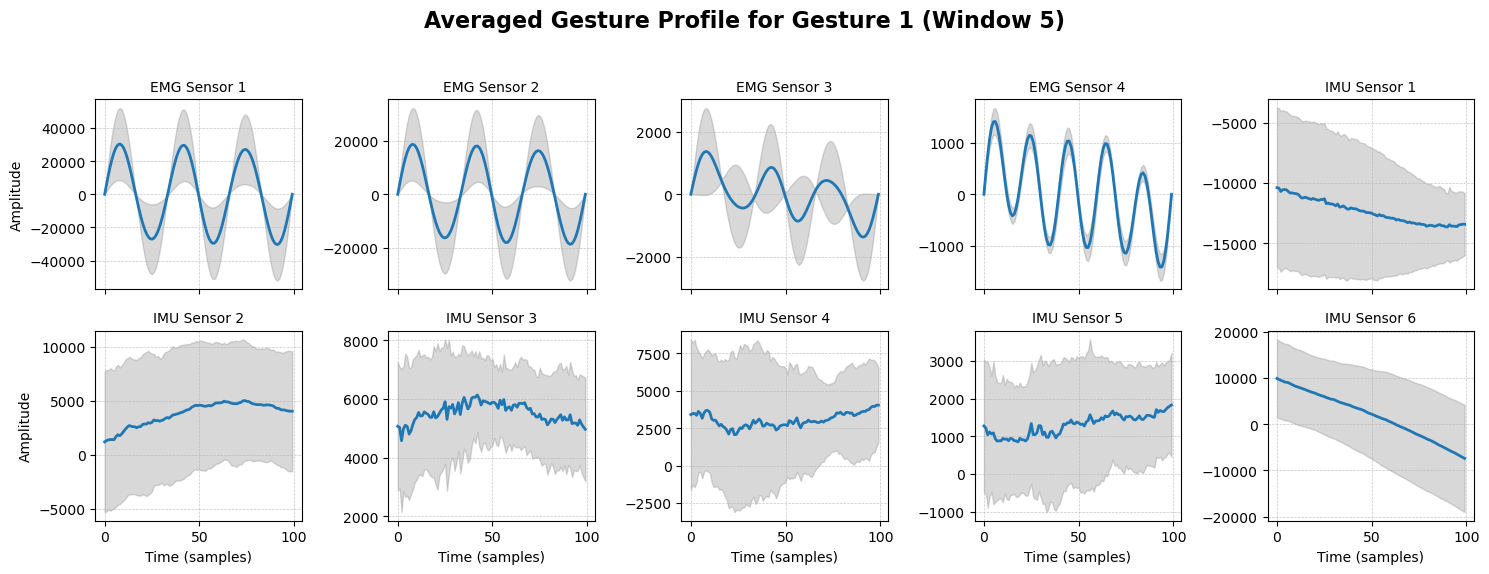

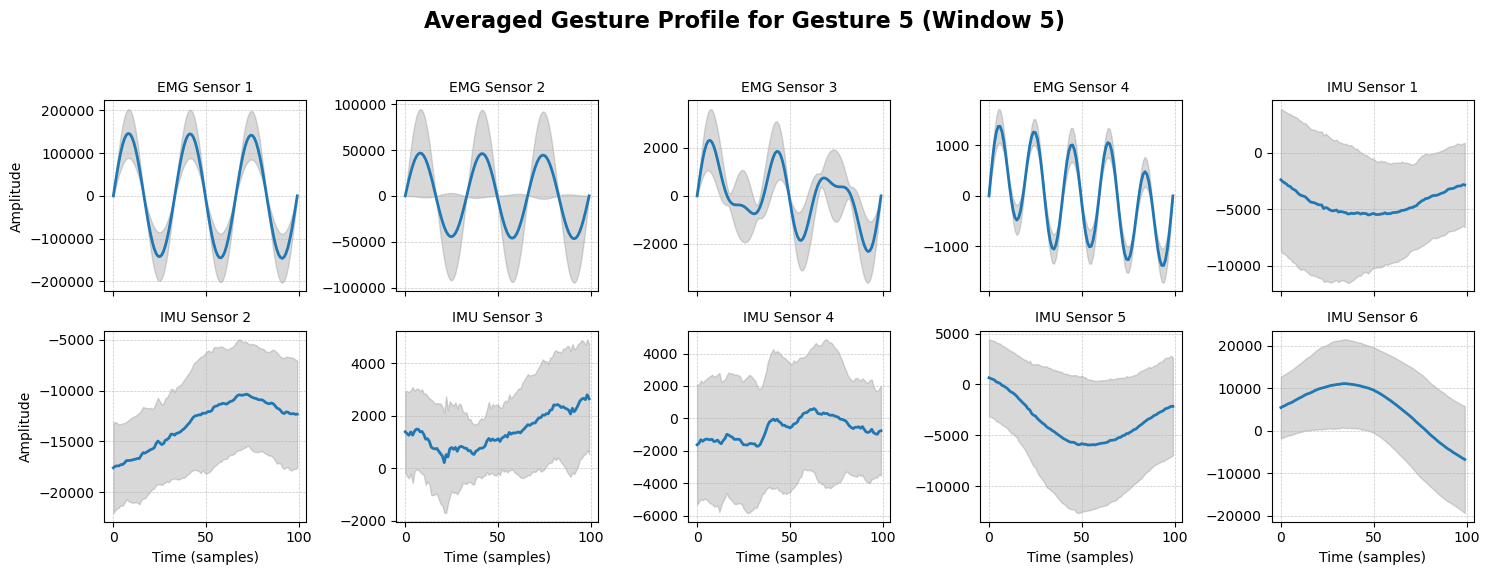

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the root path where processed data is stored

# # Load processed data and labels
# data_path = os.path.join(root_path, "processed_gesture_data.npy")
# label_path = os.path.join(root_path, "gesture_labels.npy")

# if not os.path.exists(data_path) or not os.path.exists(label_path):
#     raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")

# print("Loading processed data...")
# X = np.load(data_path, allow_pickle=True)
# y = np.load(label_path, allow_pickle=True)

# Define a helper function to extract a representative trial signal.
# If the processed data is 4D (n_trials, n_windows, window_length, n_channels),
# we select the first window as the representative window.
if X.ndim == 4:
    get_representative_trial = lambda idx: X[idx, 5, :, :]
elif X.ndim == 3:
    get_representative_trial = lambda idx: X[idx, :, :]
else:
    raise ValueError("Unexpected dimensions in processed gesture data")

# For each gesture, compute and plot the averaged gesture profile
unique_gestures = np.unique(y)

for gesture in [1, 5]: # unique_gestures
    indices = np.where(y == gesture)[0]
    if len(indices) == 0:
        continue

    # Extract a representative window from each trial for the current gesture
    trials = [get_representative_trial(idx) for idx in indices]
    trials = np.array(trials)  # Shape: (num_trials, window_length, n_channels)

    # Compute average and standard deviation across trials (axis=0)
    avg_signal = np.mean(trials, axis=0)
    std_signal = np.std(trials, axis=0)

    window_length = trials.shape[1]
    time_axis = np.arange(window_length)
    n_channels = trials.shape[2]

    # Create subplots for each sensor channel.
    # Assuming 10 channels (4 EMG and 6 IMU), we use 2 rows x 5 columns.
    nrows, ncols = 2, 5
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 6), sharex=True)
    fig.suptitle(f"Averaged Gesture Profile for Gesture {gesture} (Window 5)", fontsize=16, fontweight='bold')

    for ch in range(n_channels):
        ax = axes[ch // ncols, ch % ncols]
        # Plot the average signal with a thick line
        ax.plot(time_axis, avg_signal[:, ch], linewidth=2, label="Average")
        # Fill the area between average ± standard deviation
        ax.fill_between(time_axis,
                        avg_signal[:, ch] - std_signal[:, ch],
                        avg_signal[:, ch] + std_signal[:, ch],
                        color='gray', alpha=0.3, label="Std Dev")
        # Label sensor type: channels 0-3 are EMG, channels 4-9 are IMU
        if ch < 4:
            sensor_type = "EMG"
            sensor_id = ch + 1
        else:
            sensor_type = "IMU"
            sensor_id = ch - 3  # For example, channel 4 becomes IMU 1
        ax.set_title(f"{sensor_type} Sensor {sensor_id}", fontsize=10)
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
        if ch % ncols == 0:
            ax.set_ylabel("Amplitude", fontsize=10)
    # Set x-label on the bottom row subplots only
    for ax in axes[-1]:
        ax.set_xlabel("Time (samples)", fontsize=10)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


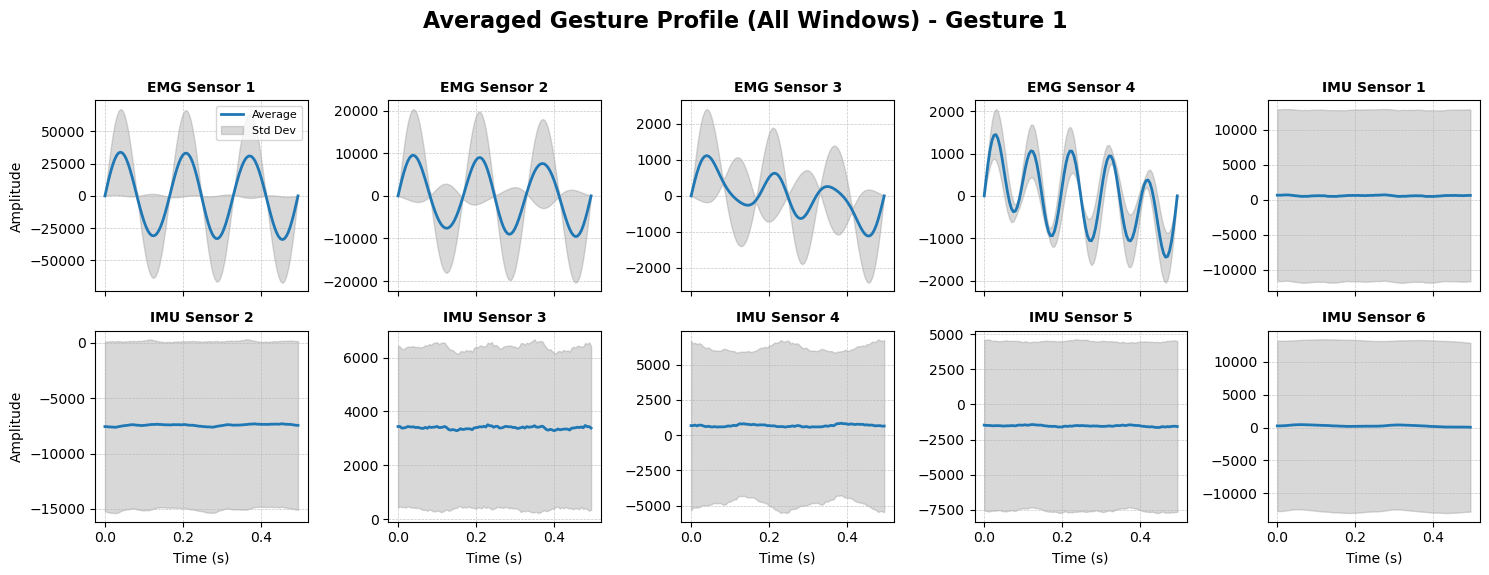

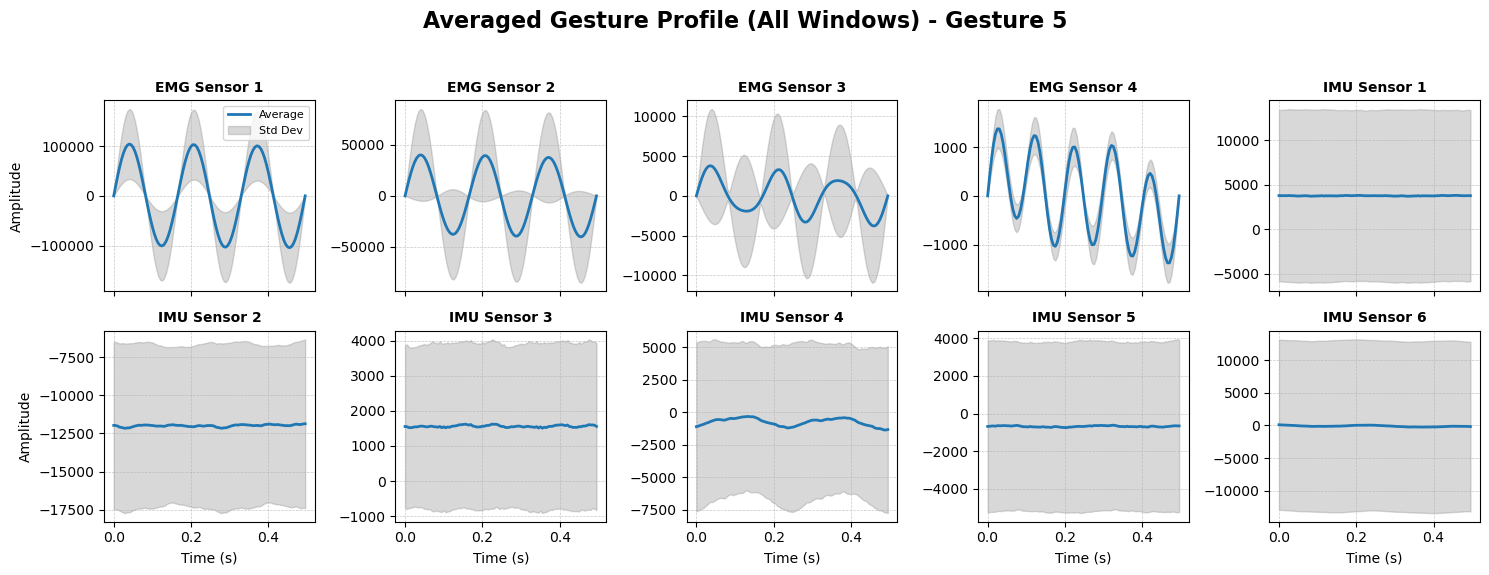

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os

##############################################################################
# USER-DEFINED: ROOT PATH, SAMPLING RATE, & GESTURES TO PLOT
##############################################################################
sampling_rate = 200             # Hz (e.g., 200 Hz); adjust as needed
gestures_to_plot = [1, 5]       # Change this list to whichever gestures you want

##############################################################################
# LOAD PROCESSED DATA
##############################################################################
# data_path = os.path.join(root_path, "processed_gesture_data.npy")
# label_path = os.path.join(root_path, "gesture_labels.npy")

# if not os.path.exists(data_path) or not os.path.exists(label_path):
#     raise FileNotFoundError("Processed gesture data or labels not found. "
#                             "Please run process_all_gesture_files first.")

# print("Loading processed data...")
# X = np.load(data_path, allow_pickle=True)
# y = np.load(label_path, allow_pickle=True)

# # Check that data is 4D: (n_trials, n_windows, window_length, n_channels)
# if X.ndim != 4:
#     raise ValueError("Expected 4D array of shape (n_trials, n_windows, window_length, n_channels).")

# print("Data shape:", X.shape)  # For debugging

##############################################################################
# FOR EACH GESTURE, AVERAGE OVER ALL WINDOWS ACROSS ALL TRIALS
##############################################################################
# unique_gestures = np.unique(y)  # If you want to plot all gestures, uncomment

for gesture in gestures_to_plot:
    # Find all trials corresponding to this gesture
    indices = np.where(y == gesture)[0]
    if len(indices) == 0:
        print(f"No trials found for Gesture {gesture}. Skipping.")
        continue

    # Concatenate all windows from these trials along axis=0
    # Shape => (n_trials * n_windows, window_length, n_channels)
    gesture_data = np.concatenate([X[idx] for idx in indices], axis=0)

    # Compute average and standard deviation across axis=0 (all windows)
    avg_signal = np.mean(gesture_data, axis=0)  # (window_length, n_channels)
    std_signal = np.std(gesture_data, axis=0)   # (window_length, n_channels)

    window_length = avg_signal.shape[0]
    n_channels = avg_signal.shape[1]

    # Convert sample indices to time in seconds
    time_axis = np.arange(window_length) / sampling_rate

    # Create a 2×5 grid of subplots for the 10 channels (4 EMG + 6 IMU).
    # Adjust if you have a different number of channels.
    nrows, ncols = 2, 5
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 6), sharex=True, sharey=False)
    axes = axes.flatten()

    fig.suptitle(f"Averaged Gesture Profile (All Windows) - Gesture {gesture}",
                 fontsize=16, fontweight='bold')

    for ch in range(n_channels):
        ax = axes[ch]
        # Plot the average signal
        ax.plot(time_axis, avg_signal[:, ch], linewidth=2, label="Average")
        # Fill the area between (avg - std) and (avg + std)
        ax.fill_between(time_axis,
                        avg_signal[:, ch] - std_signal[:, ch],
                        avg_signal[:, ch] + std_signal[:, ch],
                        color='gray', alpha=0.3, label="Std Dev")

        # Label the sensor: channels 0–3 are EMG, channels 4–9 are IMU
        if ch < 4:
            sensor_type = "EMG"
            sensor_id = ch + 1
        else:
            sensor_type = "IMU"
            sensor_id = ch - 3  # e.g., channel 4 => IMU Sensor 1

        ax.set_title(f"{sensor_type} Sensor {sensor_id}", fontsize=10, fontweight='bold')
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
        if ch // ncols == nrows - 1:  # bottom row
            ax.set_xlabel("Time (s)", fontsize=10)
        if ch % ncols == 0:          # first column
            ax.set_ylabel("Amplitude", fontsize=10)

    # Only one legend is needed; place it on the first subplot or anywhere you prefer
    axes[0].legend(fontsize=8, loc='upper right', frameon=True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
